# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Setup and dependencies</a>   
- <a href='#2'>Loading, preprocessing and exploration</a>   
- <a href='#3'>Algorithm design and setup</a>   
- <a href='#4'>Multi-layer perceptron (MLP)</a>   
- <a href='#5'>Convolutional Neural Network (CNN)</a>   
- <a href='#6'>Hyperparameter Tuning</a>   
- <a href='#7'>MLP Tuning</a>  
- <a href='#8'>CNN Tuning</a>
- <a href='#9'>Final Models</a>

> Note: Chinese characters as text currently not showing due to matplotlib error

![Table of characters](https://upload.wikimedia.org/wikipedia/commons/5/56/Chinese_numerals_financial.png)

# <a id='1'>Introduction</a>  
Both multi-layer perceptrons (MLPs) and convolutional neural networks (CNNs) perform exceeedingly well on the original MNIST digits dataset. So well in fact, that it is not hard to find simple models with very differing parameters regularly achieving >95% on the dataset across kaggle, primarily with stock keras architecture. There is good reason to then apply these model architectures built for the original MNIST on its derivatives - such as the fashion-MNIST, which was the original basis for this notebook submitted as an assignment for a Master's course at the University of Sydney. This notebook has been overhauled since then to investigate another MNIST-derivative of even greater challenge - 15 handwritten chinese characters. 

There are several key differences from the original MNIST set that make this challenge difficult. Namely, there are 5 more digits added while we also have to deal with the base similarity of several of the first three numbers in the Chinese lexicon:
* 零 - for 0  
* 一 - for 1
* 二 - for 2  
* 三 - for 3  
* 四 - for 4  
* 五 - for 5  
* 六 - for 6  
* 七 - for 7  
* 八 - for 8  
* 九 - for 9  
* 十 - for 10
* 百 - for 100
* 千 - for 1000
* 万 - for 10 thousand
* 亿 - for 100 million

Highly complex digits, such as 五 - 5, should be easier to classify for both models given high difference when training, while the CNN filters will have a particularly difficult time differentiating 一, 二 and 三. 

As seen in this notebook, initial accuracies are far lower than that which we might see in a typical MNIST setup. All architectures in this notebook are referenced from sources originally applying them to MNIST datasets, before I have made my own tunings based on suitability for the Chinese MNIST.

We start by quickly exploring the data and setting up our neural networks, before doing some exploratory models that help us decide which parameters are suitable to carry forward to hyper-parameter tuning, which can be a very expensive exercise, as seen in the runtimes. 

The final and best parameters delivered via the GridSearchCV form the evaluative model that is performed on the test set, having been trained and validated on a train & validation split. 

High accuracies are almost delivered by the hyper-parameter tuning, and unsurprisingly the computationally-expensive CNN performed the best, as it should for image recognition. 

萬歲!

# <a id='2'>Setup and dependencies</a>  

In [44]:
#Sometimes a tensorflow upgrade is required to use scikeras properly, depending on whether we installed in a virtual or root environment
!pip install --upgrade tensorflow

^C
ERROR: Operation cancelled by user


In [45]:
# Install scikeras if not present
!pip install scikeras

^C
ERROR: Operation cancelled by user


In [54]:
# base
import numpy as np
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier

# my own
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
from time import time
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report




In [181]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap=plt.cm.binary)
  plt.rcParams['font.sans-serif'] = ['SimHei']

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color,fontsize=12)



def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

# <a id='2'>Data loading, preprocessing, and exploration</a>  
We will load the data as a pandas dataframe, Aand flip it back and forth as a numpy array depending on the task.

The Chinese MNIST dataset is rather large - 100 volunteers providing 10 samples of each of the 15 characters. This makes it a formidable dataset like its parent, but fundamentally different in the consideration of how neural networks will react to Chinese orthography. Building a good model that is sufficiently small is helpful in so far as the applications of training on Chinese-text based datasets from images or handwriting is much more difficult given the larger number of characters compared to English.

In [56]:
csv = pd.read_csv("../input/chinese-mnist/chinese_mnist.csv")
csv.head(100)

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九
...,...,...,...,...,...
95,17,5,10,9,九
96,17,6,10,9,九
97,17,7,10,9,九
98,17,8,10,9,九


We iterate through the dataset to one-hot encode the data with the relevant class example, represented as an array with a '1' value in the position for which element it belongs out of the 15. For example, the third element corresponds to the number 三. 

In [57]:
df = pd.read_csv("../input/chinese-mnist/chinese_mnist.csv")

X = []
y = []
for row in csv.itertuples():
    suite_id = row[1]
    sample_id = row[2]
    code = row[3]
    file_name = f"input_{suite_id}_{sample_id}_{code}.jpg"
    x = cv2.imread(f"../input/chinese-mnist/data/data/{file_name}")
    X.append(x)
    one_hot = [0] * 15
    one_hot[code - 1] = 1
    y.append(one_hot)
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y)

We perform one initial split and check the shape before moving onto a validation split

In [58]:
print(X_train.shape)
print(X_test.shape)

(11250, 64, 64, 3)
(3750, 64, 64, 3)


In [185]:
# An ordered list of the class names
class_names = ["零 0",
               "一 1",
               "二 2",
               "三 3",
               "四 4",
               "五 5",
               "六 6",
               "七 7",
               "八 8",
               "九 9",
               "十 10",
               "百 100",
               "千 1000",
               "万 10,000",
               "亿 100 Million"
              ]

We can plot a grid of examples that show the intricate characters:

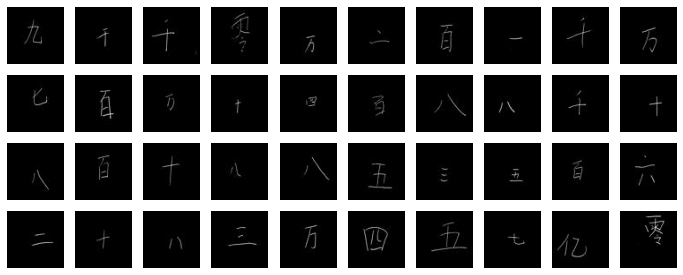

In [170]:
def plot_examples(data, n_rows=4, n_cols=10):
    """Plot a grid of MNIST examples of a specified size."""
    
    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    
    for row in range(n_rows):
        for col in range(n_cols):
            
            # Get next index of image
            index = n_cols * row + col
            
            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index], cmap="binary")
            plt.axis('off')
            
    plt.show()

plot_examples(X_train)

In [61]:
#Check image type
X_train.dtype

dtype('uint8')

Since the type of the image is uint8, we know its range is restricted of grayscale values from 1-255. Thus, to scale, we simply divide by the max value (255) which represents a fully white pixel in terms of intensity - (0 being a dark pixel).

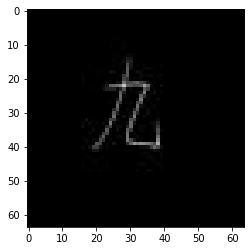

In [62]:
#Before scaling
plt.imshow(X_train[0], cmap="binary")
plt.show()

In [63]:
# Scaling
X_train = X_train / 255.
X_test = X_test / 255.
# Validation split

X_train_v, X_valid, y_train_v, y_valid = train_test_split(X_train, y_train, train_size=0.8)

print(f"Shape of X_train_v (X train): {X_train_v.shape}")
print(f"Shape of X_valid (X validation train): {X_valid.shape}")
print(f"Shape of y_train_v (y validation train): {y_train_v.shape}")
print(f"Shape of y_valid (y validation test): {y_valid.shape}")

Shape of X_train_v (X train): (9000, 64, 64, 3)
Shape of X_valid (X validation train): (2250, 64, 64, 3)
Shape of y_train_v (y validation train): (9000, 15)
Shape of y_valid (y validation test): (2250, 15)


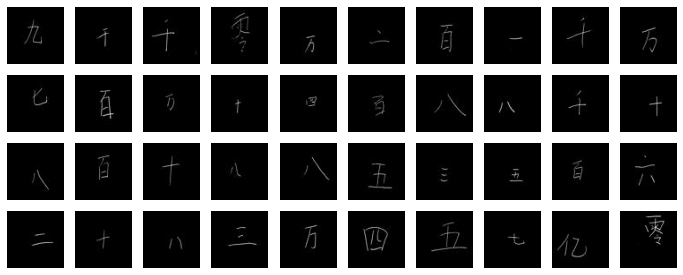

In [64]:
def plot_examples(data, n_rows=4, n_cols=10):
    """Plot a grid of MNIST examples of a specified size."""
    
    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    
    for row in range(n_rows):
        for col in range(n_cols):
            
            # Get next index of image
            index = n_cols * row + col
            
            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index], cmap="binary")
            plt.axis('off')
            
    plt.show()

plot_examples(X_train)

The images are well centred, though certainly not as well as we might see in MNIST or fashion MNIST. It may be difficult for a filter to adequately recognize all parts of the strokes. 

In [65]:
# Check unique labels
print(y_train[0:5])

# List all unique labels in the training set
print(np.unique(y_train))

[[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]
[0 1]


As mentioned before, we can see the first five training labels as arrays, where the element in a given position corresponds to the given class (number). We can do a final check for unique values before setting up the algorithm.

# <a id='3'>Algorithm design and setup </a>  

There are two predictors we are testing, both in the keras neural network family. First, an MLP with a few different architectures (Model 1 based on MNIST digits and Model 2 based on cursory research for Fashion MNIST and Chinese MNIST) and second is a group of CNNs. We should expect the CNNs to perform remarkably better given the complexity of the images and the difficulty in finding linear seperations that are important for quick MLPs. The MLPs of course are far faster, so it would be preferable to tune them to a good standard. 

This initial design and setup stage serves the purpose of finding which parameters are worthy of tuning and which are not. As with all neural networks, literally everything is a black box until the code runs, so it is important to spend a bit time playing with the parameters that are easily interpretable between rough models, such as epochs and number of layers and neurons. Ultimately, only the GridSearchCV is the arbiter of truth, provided we ask the right questions. We will explore some common architectures and compare their validation results to see which parameters have the most promise at tuning the best models.

### <a id='4'>Fully connected neural network MLP </a>  

##### Model 1: Classic MNIST models

- Two-layer setup with 300 and 100 neurons per layer respectively
- Tanh activation function
- Uses Stochastic Gradient Descent (SGD) optimizer with a 0.1 learning rate

In [66]:
# Typical MLP MNIST model
model = keras.models.Sequential([
keras.layers.Flatten(input_shape=[64, 64, 3]),
keras.layers.Dense(300, activation="tanh"),
keras.layers.Dense(100, activation="tanh"),
keras.layers.Dense(15, activation="softmax")])

In [67]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 12288)             0         
                                                                 
 dense_19 (Dense)            (None, 300)               3686700   
                                                                 
 dense_20 (Dense)            (None, 100)               30100     
                                                                 
 dense_21 (Dense)            (None, 15)                1515      
                                                                 
Total params: 3,718,315
Trainable params: 3,718,315
Non-trainable params: 0
_________________________________________________________________


In [68]:
opt = keras.optimizers.SGD(learning_rate=5e-2)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [69]:
start = time()
history = model.fit(X_train_v, y_train_v, epochs=20,
                    validation_data=(X_valid, y_valid))
print('\n Time for Model 1 NN to train = {:.0f} sec'.format(time()-start))

Epoch 1/20
282/282 [==============================] - 5s 17ms/step - loss: 2.2217 - accuracy: 0.3554 - val_loss: 1.9293 - val_accuracy: 0.4298
Epoch 2/20
282/282 [==============================] - 4s 15ms/step - loss: 1.7176 - accuracy: 0.5060 - val_loss: 1.7392 - val_accuracy: 0.4756
Epoch 3/20
282/282 [==============================] - 4s 15ms/step - loss: 1.5441 - accuracy: 0.5512 - val_loss: 1.6862 - val_accuracy: 0.4853
Epoch 4/20
282/282 [==============================] - 4s 15ms/step - loss: 1.4433 - accuracy: 0.5776 - val_loss: 1.6579 - val_accuracy: 0.5004
Epoch 5/20
282/282 [==============================] - 4s 15ms/step - loss: 1.3612 - accuracy: 0.6024 - val_loss: 1.6564 - val_accuracy: 0.5067
Epoch 6/20
282/282 [==============================] - 4s 15ms/step - loss: 1.2801 - accuracy: 0.6240 - val_loss: 1.6008 - val_accuracy: 0.5196
Epoch 7/20
282/282 [==============================] - 4s 15ms/step - loss: 1.1987 - accuracy: 0.6483 - val_loss: 1.5487 - val_accuracy: 0.5316

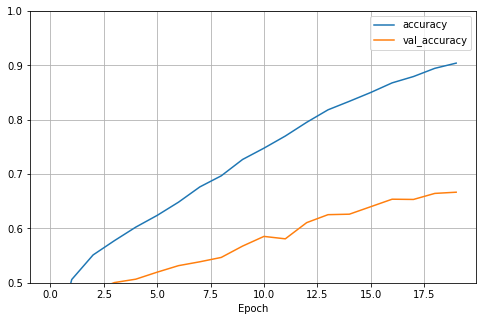

In [70]:
# Convert the history dictionary to a Pandas dataframe and extract the accuracies
accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]

# Plot the accuracies
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.5, 1)
plt.xlabel('Epoch')
plt.show()

##### Model 2: Researched for MNIST-Chinese

- Uses ADAM optimizer with smaller learning rate
- Possibly efficient with smaller number of epochs
- Single layer with 128 neurons is roughly as effective as dual layer

In [71]:
#Reinstantiate
model = keras.models.Sequential([
keras.layers.Flatten(input_shape=[64, 64, 3]),
keras.layers.Dense(256, activation="relu"),
keras.layers.Dense(15, activation="softmax")
])
opt = keras.optimizers.Adam(0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Epoch 1/10
282/282 [==============================] - 7s 24ms/step - loss: 1.7489 - accuracy: 0.4749 - val_loss: 1.2879 - val_accuracy: 0.6276
Epoch 2/10
282/282 [==============================] - 7s 24ms/step - loss: 0.8520 - accuracy: 0.7607 - val_loss: 0.9474 - val_accuracy: 0.7116
Epoch 3/10
282/282 [==============================] - 7s 24ms/step - loss: 0.4855 - accuracy: 0.8757 - val_loss: 0.7818 - val_accuracy: 0.7569
Epoch 4/10
282/282 [==============================] - 6s 23ms/step - loss: 0.2966 - accuracy: 0.9343 - val_loss: 0.7351 - val_accuracy: 0.7796
Epoch 5/10
282/282 [==============================] - 6s 23ms/step - loss: 0.1856 - accuracy: 0.9658 - val_loss: 0.7197 - val_accuracy: 0.7844
Epoch 6/10
282/282 [==============================] - 6s 23ms/step - loss: 0.1238 - accuracy: 0.9800 - val_loss: 0.7084 - val_accuracy: 0.7947
Epoch 7/10
282/282 [==============================] - 7s 25ms/step - loss: 0.0856 - accuracy: 0.9884 - val_loss: 0.7348 - val_accuracy: 0.7911

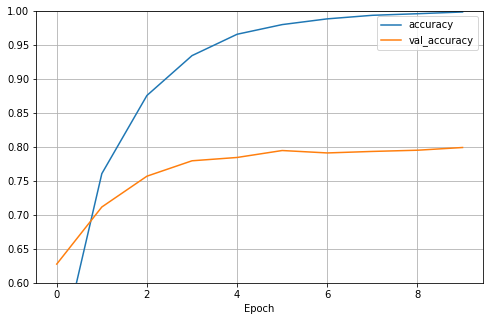

In [72]:
start = time()
history = model.fit(X_train_v, y_train_v, epochs=10,
                    validation_data=(X_valid, y_valid))
print('\n Time for Model 1 NN to train = {:.0f} sec'.format(time()-start))

#Plot again
accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.6, 1)
plt.xlabel('Epoch')
plt.show()

There is a noticeable deviation in accuracy from early in the validation accuracy curve, suggesting that more epochs might not necessarily prove better results. This gives good incentive to cut epochs from the hyperparameter tuning of the NN model.

Evidence of overfitting very present, with validation accuracy struggling beyond ~80%. We can hyper-parameter tune to find the best combinations. Adam optimiser likely best given the immediate improvement. 

### <a id='5'>Convolutional Neural Network (CNN)</a>  

The convolutional neural network architecture was also derived and scrutinized according to external sources. Most sources appeared to recommend two convolutional layers with subsequent pooling blocks. Kernel size should usually be smaller, odd-size values for best results (https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363). We will therefore start with a consistent kernel size of 3x3 for initial investigation into the models. While a larger kernel size (and thus more more computationlly intensive) will be considered for hyper-parameter tuning, we will again do a rough comparison of epochs so we do not have to investigate them in the GridSearch. 

In terms of number of layers, various sources agreed at least two layers was standard, but this was up for debate. In order to see whether two convolutional layers was necessary or one was enough, a single convolutional layer and pool block was tested against two. As per MNIST-informed architecture, the size of the first hidden layer was 32 neurons and 64 in the second. The single-layer with pool block was kept at 32 neurons to see success at mininum levels of complexity. 

MaxPooling is the obvious choice for all MNIST and MNIST-related derivatives, given that images are single channel on an empty background. While I originally did some runs on average pooling to see any efficacy, it was clear that MaxPooling on both layers was marginally better and far more intuitive. There are a few reasons why average pooling could work. Given some gaps and complex outlines for the clothing images, average pooling may be able to better differentiate the general outline, especially if there is some lighter pixel values in the middle of a clothing item, such as a white logo panel on a shirt. MaxPooling might build a silhouette around these white pixels, whereas average pooling might better differentiate that this is a feature of the specific shirt, and not of the shirt class as a whole.


Similar to the fully-connected NN, the activation function is difficult to effectively determine as to which option is best. Sources indicate that like a fully-connected NN, "relu" was most versatile in application, albeit with risk of overfitting. Since we are primarily interested in kernel size for hyperparameter tuning, "relu" was again selected for  all hidden layers in this initial rough comparison.

Dropout (0.5) and learning rates were kept at defaults (0.01), combined again with an "Adam" optimiser. Since we do not intend to run GridSearch over the optimisers, a versatile and reliable optimiser like "Adam" is a safe choice. 

On the dual-layer model, epochs were run at 10 and 20 values in order to ascertain an visually discernable increase. 


In [73]:
model = keras.Sequential([
    
    # Conv and pool block 1
    keras.layers.Conv2D(32, kernel_size=(3, 3),input_shape=(64, 64, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Conv and pool block 2
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    #Dropout
    keras.layers.Dropout(0.5),
    
    # Flatten and classify using dense output layer
    keras.layers.Flatten(),

    keras.layers.Dense(15, activation="softmax"),
])

In [74]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 flatten_15 (Flatten)        (None, 12544)           

In [75]:
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [76]:
batch_size = 128
epochs = 10
start = time()
history = model.fit(X_train_v, y_train_v, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))
print('\n Time for CNN to train with 10 epochs = {:.0f} sec'.format(time()-start))

Epoch 1/10
71/71 [==============================] - 31s 428ms/step - loss: 1.8942 - accuracy: 0.4213 - val_loss: 1.2937 - val_accuracy: 0.6138
Epoch 2/10
71/71 [==============================] - 30s 419ms/step - loss: 0.9452 - accuracy: 0.7168 - val_loss: 0.7252 - val_accuracy: 0.7836
Epoch 3/10
71/71 [==============================] - 30s 422ms/step - loss: 0.6289 - accuracy: 0.8027 - val_loss: 0.5521 - val_accuracy: 0.8244
Epoch 4/10
71/71 [==============================] - 30s 423ms/step - loss: 0.5066 - accuracy: 0.8350 - val_loss: 0.4711 - val_accuracy: 0.8680
Epoch 5/10
71/71 [==============================] - 30s 425ms/step - loss: 0.4157 - accuracy: 0.8653 - val_loss: 0.4076 - val_accuracy: 0.8796
Epoch 6/10
71/71 [==============================] - 30s 425ms/step - loss: 0.3596 - accuracy: 0.8847 - val_loss: 0.3707 - val_accuracy: 0.8840
Epoch 7/10
71/71 [==============================] - 30s 424ms/step - loss: 0.3082 - accuracy: 0.9009 - val_loss: 0.3327 - val_accuracy: 0.9018

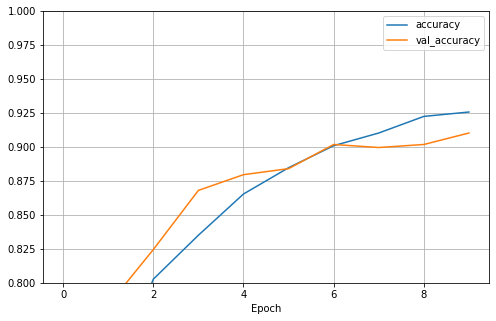

In [77]:
accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 1)
plt.xlabel('Epoch')
plt.show()

(9000, 64, 64, 3) (9000, 15)
Epoch 1/10
71/71 [==============================] - 30s 407ms/step - loss: 2.0568 - accuracy: 0.3684 - val_loss: 1.5857 - val_accuracy: 0.5404
Epoch 2/10
71/71 [==============================] - 29s 410ms/step - loss: 1.3047 - accuracy: 0.6150 - val_loss: 1.0649 - val_accuracy: 0.6862
Epoch 3/10
71/71 [==============================] - 29s 413ms/step - loss: 0.8860 - accuracy: 0.7300 - val_loss: 0.7812 - val_accuracy: 0.7773
Epoch 4/10
71/71 [==============================] - 29s 409ms/step - loss: 0.7026 - accuracy: 0.7792 - val_loss: 0.6530 - val_accuracy: 0.8102
Epoch 5/10
71/71 [==============================] - 30s 418ms/step - loss: 0.5932 - accuracy: 0.8084 - val_loss: 0.5924 - val_accuracy: 0.8191
Epoch 6/10
71/71 [==============================] - 29s 411ms/step - loss: 0.5306 - accuracy: 0.8301 - val_loss: 0.5347 - val_accuracy: 0.8302
Epoch 7/10
71/71 [==============================] - 29s 410ms/step - loss: 0.4806 - accuracy: 0.8432 - val_loss: 

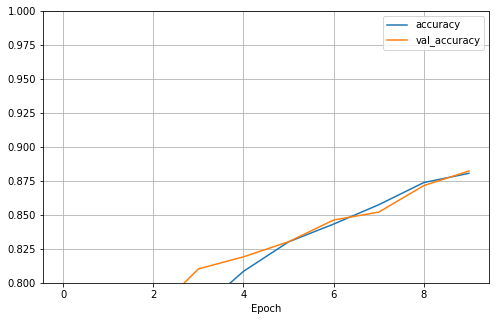

In [78]:
#Reinstantiate to try Average Pooling with 2 layers for fun before moving to single-layer
model = keras.Sequential([
    
    # Conv and pool block 1
    keras.layers.Conv2D(32, kernel_size=(3, 3),input_shape=(64, 64, 3), activation="relu"),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    
    # Conv and pool block 2
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    
    #Dropout
    keras.layers.Dropout(0.5),
    
    # Flatten and classify using dense output layer
    keras.layers.Flatten(),

    keras.layers.Dense(15, activation="softmax"),
])

print(X_train_v.shape, y_train_v.shape)
#Bump epochs to 20
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
batch_size = 128
epochs = 10
start = time()
history = model.fit(X_train_v, y_train_v, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))
print('\n Time for CNN to train with 10 epochs and AveragePooling 2 layers = {:.0f} sec'.format(time()-start))

accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 1)
plt.xlabel('Epoch')
plt.show()

(9000, 64, 64, 3) (9000, 15)
Epoch 1/20
71/71 [==============================] - 17s 234ms/step - loss: 1.9894 - accuracy: 0.4107 - val_loss: 1.5530 - val_accuracy: 0.5387
Epoch 2/20
71/71 [==============================] - 17s 238ms/step - loss: 1.3162 - accuracy: 0.6183 - val_loss: 1.2463 - val_accuracy: 0.6329
Epoch 3/20
71/71 [==============================] - 16s 231ms/step - loss: 1.0145 - accuracy: 0.7110 - val_loss: 1.0355 - val_accuracy: 0.7027
Epoch 4/20
71/71 [==============================] - 17s 238ms/step - loss: 0.8128 - accuracy: 0.7673 - val_loss: 0.8659 - val_accuracy: 0.7547
Epoch 5/20
71/71 [==============================] - 16s 231ms/step - loss: 0.6762 - accuracy: 0.8063 - val_loss: 0.7727 - val_accuracy: 0.7742
Epoch 6/20
71/71 [==============================] - 17s 237ms/step - loss: 0.5836 - accuracy: 0.8307 - val_loss: 0.7214 - val_accuracy: 0.7858
Epoch 7/20
71/71 [==============================] - 16s 228ms/step - loss: 0.5130 - accuracy: 0.8507 - val_loss: 

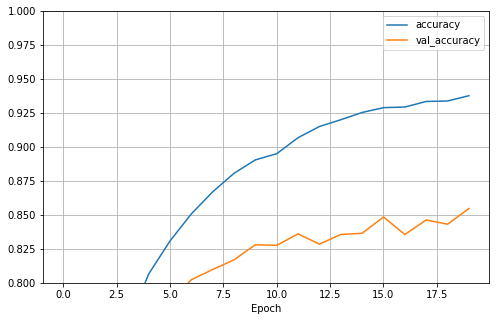

In [79]:
#Reinstantiate with only one Conv layer and pooling block, retain 20 epochs
model = keras.Sequential([
    
    # Specify the input shape
    
    # Conv and pool block 1
    keras.layers.Conv2D(32, kernel_size=(3, 3),input_shape=(64, 64, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),   
    
    #Dropout
    keras.layers.Dropout(0.5),

    # Flatten and classify using dense output layer
    
    keras.layers.Flatten(),
    keras.layers.Dense(15, activation="softmax"),
])

print(X_train_v.shape, y_train_v.shape)
#Bump epochs to 20 for double comparison
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
batch_size = 128
epochs = 20
start = time()
history = model.fit(X_train_v, y_train_v, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))
print('\n Time for CNN to train with 20 epochs = {:.0f} sec'.format(time()-start))

accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 1)
plt.xlabel('Epoch')
plt.show()

Dual convolutional layer with accompanying pool block accuracy proved an acceptable value, making hyper-parameter very computationally intensive when we get down to it. The single layer CNN did not perform well enough to carry forward, given the remarkable validation accuracy of the dual layer system. Achieving 80% validation accuracy should be a benchmark, but by only tuning a few parameters in the GridSearchCV, we can hopefully reduce time to fit.

# <a id='6'>Hyperparameter Tuning</a> 

### <a id='7'>MLP Tuning</a> 

Although the MNIST dual-layer NN setup produced an impressively high result, I opted to conduct hyper-parameter tuning on a single-layer model derived from the rough testing in the prior section. By using a single-layer, we are better able to see the direct changes that hyperparameters have on the output of the model, all of which had accuracies hovering around ~90%. 

Because I suspect the relative sucess of the dual-layer setup might be due to large number of neurons in initial layer (300), I will also tune for neuron size in the single layer setup. Thus, the parameters to be tuned are learning rates, amount of neurons and the activation function. These are the key differences (aside from the initial difference of either one or two hidden layers) between the original MNIST model imported and the model created from cursory research. In this attempt to arrive at a single-layer structure that is concise yet efficiently generating accurate results, epochs will be restricted to 10 to reduce tuning time while concentrating differences in performance on the actual input parameters of the NN. 

In [82]:
def build_mlp(
    n_hidden_layers=1, n_hidden_neurons=50,
    activation_function="relu", input_shape=[64,64,3]
):

    # initial testing demonstrated one large hidden layer is enough for high accuracy readings >90%
    # activation function and neuron size are subject to investigation
    
    model = keras.models.Sequential()
    
    # Add the input layer
    model.add(keras.layers.Flatten(input_shape=input_shape))
    
    # Add the hidden layers with desired size and activation function
    for layer in range(n_hidden_layers):
        model.add(keras.layers.Dense(n_hidden_neurons, activation=activation_function))
        
    # Add the output layer for 15 class classification
    model.add(keras.layers.Dense(15, activation="softmax"))
    
    return model

In [83]:
# Create a KerasClassifier object which works with sklearn grid searches
# We need to pass default values of arguments in build_mlp if we wish to tune them
keras_classifier_NN = KerasClassifier(build_mlp,
                                   n_hidden_layers=1,
                                   n_hidden_neurons=50,
                                   activation_function="relu",
                                   loss="categorical_crossentropy",
                                   optimizer="Adam",
                                   #As noted prior, the default will be Adam with no need to investigate SGD
                                   optimizer__lr=0.001,
                                   metrics=["accuracy"]
                                  )

In [84]:
start = time()

param_grid = {
    "n_hidden_neurons": [128, 256, 512],
    "optimizer__lr": [0.1, 0.01, 0.001],
    # 10 epochs proved enough for the MLP prior
    "epochs": [10],
    "optimizer": ["Adam"],
    #Note: Adam does not work well with learning rates above 0.01
    "activation_function": ["relu", 
                            "tanh"]
}

grid_search_cv = GridSearchCV(keras_classifier_NN, param_grid, cv=3, verbose=2)
grid_search_cv.fit(X_train_v, y_train_v)

print('time for grid search = {:.0f} sec'.format(time()-start))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Epoch 1/10
188/188 [==============================] - 3s 13ms/step - loss: 2.0803 - accuracy: 0.3823
Epoch 2/10
188/188 [==============================] - 2s 13ms/step - loss: 1.5780 - accuracy: 0.5517
Epoch 3/10
188/188 [==============================] - 2s 13ms/step - loss: 1.3650 - accuracy: 0.5977
Epoch 4/10
188/188 [==============================] - 2s 13ms/step - loss: 1.2058 - accuracy: 0.6390
Epoch 5/10
188/188 [==============================] - 3s 13ms/step - loss: 1.0964 - accuracy: 0.6633
Epoch 6/10
188/188 [==============================] - 2s 13ms/step - loss: 1.0072 - accuracy: 0.6928
Epoch 7/10
188/188 [==============================] - 2s 13ms/step - loss: 0.9377 - accuracy: 0.7152
Epoch 8/10
188/188 [==============================] - 2s 13ms/step - loss: 0.8762 - accuracy: 0.7342
Epoch 9/10
188/188 [==============================] - 2s 13ms/step - loss: 0.8271 - accuracy: 0.7500
Epoch 10/10
94/94 [===========

In [85]:
print("Validation set score: {:.2f}".format(grid_search_cv.score(X_train_v, y_train_v)))
print(grid_search_cv.best_params_)
print(grid_search_cv.best_score_)

282/282 [==============================] - 3s 9ms/step
Validation set score: 1.00
{'activation_function': 'relu', 'epochs': 10, 'n_hidden_neurons': 512, 'optimizer': 'Adam', 'optimizer__lr': 0.1}
0.7651111111111111


There is something wrong with the GridSearch output for best_score_, but luckily we can still observe the best parameters via the history print. As such, we can see the best parameters (finishing with the highest accuracy) are {'activation_function': 'relu', 'epochs': 10, 'n_hidden_neurons': 512, 'optimizer': 'Adam', 'optimizer__lr': 0.001} - only a small change in learning rate to bring it back.

### <a id='8'>CNN Tuning</a> 

In [137]:
def build_cnn(
    pool_type='max', kernel_size = (3, 3), strides = (1,1)):
    
    model = keras.Sequential([
    
    keras.layers.Conv2D(32, kernel_size=kernel_size, strides = strides, input_shape=(64, 64, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
    keras.layers.Conv2D(64, kernel_size=kernel_size, strides = strides, activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
    keras.layers.Dropout(0.5),
     
    keras.layers.Flatten(),

    keras.layers.Dense(15, activation="softmax"),
    ])
    return model

In [138]:
keras_classifier_CNN = KerasClassifier(build_cnn,
                            pool_type='max',
                            kernel_size = (3, 3),
                            strides= (1, 1),
                            loss="categorical_crossentropy",
                            optimizer="Adam",
                            #As noted prior, the default will be Adam and our initial tuning demonstrated good results
                            optimizer__lr=0.001,
                            metrics=["accuracy"]
                            )

In [139]:
start = time()

# define parameters and values for grid search 
param_grid = {
    'kernel_size': [(3,3),(5,5)],
    'strides': [(1,1),(2,2)],
    # Since we are using the Adam optimiser, we can remove the 0.1 learning rate given poor performance so far and reduce the time to search
    'optimizer__lr': [0.01, 0.001],
    "epochs": [20]
}

grid_search_cv = GridSearchCV(keras_classifier_CNN, param_grid, cv=3, verbose=2)
grid_search_cv.fit(X_train_v, y_train_v)

# summarize results
print('time for grid search = {:.0f} sec'.format(time()-start))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Epoch 1/20
188/188 [==============================] - 19s 98ms/step - loss: 1.5244 - accuracy: 0.5248
Epoch 2/20
188/188 [==============================] - 18s 96ms/step - loss: 0.6790 - accuracy: 0.7863
Epoch 3/20
188/188 [==============================] - 18s 93ms/step - loss: 0.4583 - accuracy: 0.8532
Epoch 4/20
188/188 [==============================] - 18s 95ms/step - loss: 0.3391 - accuracy: 0.8930
Epoch 5/20
188/188 [==============================] - 18s 94ms/step - loss: 0.2784 - accuracy: 0.9053
Epoch 6/20
188/188 [==============================] - 18s 96ms/step - loss: 0.2226 - accuracy: 0.9212
Epoch 7/20
188/188 [==============================] - 17s 93ms/step - loss: 0.2102 - accuracy: 0.9308
Epoch 8/20
188/188 [==============================] - 18s 95ms/step - loss: 0.1689 - accuracy: 0.9447
Epoch 9/20
188/188 [==============================] - 18s 93ms/step - loss: 0.1567 - accuracy: 0.9450
Epoch 10/20
188/188 [=

In [140]:
print("Validation set score: {:.2f}".format(grid_search_cv.score(X_train_v, y_train_v)))
print(grid_search_cv.best_params_)
print(grid_search_cv.best_score_)

282/282 [==============================] - 2s 8ms/step
Validation set score: 0.99
{'epochs': 20, 'kernel_size': (5, 5), 'optimizer__lr': 0.01, 'strides': (2, 2)}
0.9659999999999999


We will carry forward the above parameters gleaned from observing the history print into the final CNN architecture. We should note the surprise in that both a larger kernel value and a larger stride value appear to better capture the minutiae of features in Chinese characters.

# <a id='9'>Final Models & Best Parameters</a> 

Having obtained the best parameters from the lengthy gridsearch, we can plug them into our final model architecture and evaluate on the test set for the first and last time:

### 1. MLP best parameters and model

The final paramaters for the MLP as per our inspection of the grid search were:
- No. of hidden neurons: 512
- Learning rate: 0.001
- Activation function: 'relu'

In [141]:
#Reinstantiate
#Set to parameters from GridSearchCV
activation_function = 'relu'
n_hidden_neurons= 512
optimizer__lr= 0.001
epochs= 10

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[64, 64,3]),
    keras.layers.Dense(n_hidden_neurons, activation= activation_function),
    keras.layers.Dense(15, activation="softmax")
])

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(optimizer__lr),
              metrics=['accuracy'])
start = time()
history = model.fit(X_train_v, y_train_v, epochs= epochs,
                    validation_data=(X_valid, y_valid))
print('\n Time to train for final fully-connected NN model = {:.0f} sec'.format(time()-start))

Epoch 1/10
282/282 [==============================] - 14s 47ms/step - loss: 1.6205 - accuracy: 0.5144 - val_loss: 1.1078 - val_accuracy: 0.6680
Epoch 2/10
282/282 [==============================] - 12s 44ms/step - loss: 0.6652 - accuracy: 0.8133 - val_loss: 0.7776 - val_accuracy: 0.7547
Epoch 3/10
282/282 [==============================] - 12s 43ms/step - loss: 0.3295 - accuracy: 0.9163 - val_loss: 0.6765 - val_accuracy: 0.7836
Epoch 4/10
282/282 [==============================] - 12s 44ms/step - loss: 0.1768 - accuracy: 0.9636 - val_loss: 0.6497 - val_accuracy: 0.8022
Epoch 5/10
282/282 [==============================] - 12s 43ms/step - loss: 0.1053 - accuracy: 0.9813 - val_loss: 0.6365 - val_accuracy: 0.8138
Epoch 6/10
282/282 [==============================] - 12s 44ms/step - loss: 0.0634 - accuracy: 0.9920 - val_loss: 0.6397 - val_accuracy: 0.8107
Epoch 7/10
282/282 [==============================] - 12s 43ms/step - loss: 0.0440 - accuracy: 0.9937 - val_loss: 0.6274 - val_accuracy:

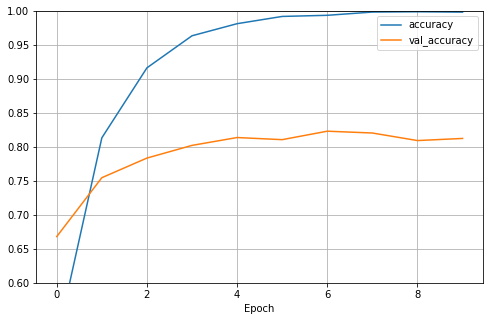

In [142]:
#Plot again
accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.6, 1)
plt.xlabel('Epoch')
plt.show()

In [143]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
30/30 [==============================] - 1s 22ms/step - loss: 0.6383 - accuracy: 0.8336
test loss, test acc: [0.6382913589477539, 0.8335999846458435]


In [144]:
#https://www.tensorflow.org/tutorials/keras/classification
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(X_test)

118/118 [==============================] - 1s 10ms/step


In [145]:
#Sourced from: https://stackoverflow.com/questions/42279055/comparing-metrics-of-keras-with-metrics-of-sklearn-classification-report
predicted_classes = np.argmax(predictions, axis=1)
rounded_labels=np.argmax(y_test, axis=1)
print(classification_report(rounded_labels, predicted_classes, target_names=class_names))

                 precision    recall  f1-score   support

          零 = 0       0.89      0.95      0.92       279
          一 = 1       0.96      0.97      0.96       229
          二 = 2       0.83      0.80      0.81       251
          三 = 3       0.81      0.82      0.82       252
          四 = 4       0.88      0.90      0.89       253
          五 = 5       0.87      0.81      0.84       246
          六 = 6       0.83      0.82      0.83       247
          七 = 7       0.85      0.82      0.84       258
          八 = 8       0.94      0.95      0.95       264
          九 = 9       0.77      0.74      0.75       271
         十 = 10       0.86      0.79      0.82       226
        百 = 100       0.73      0.76      0.74       256
       千 = 1000       0.71      0.82      0.76       220
     万 = 10,000       0.77      0.75      0.76       242
亿 = 100 Million       0.81      0.80      0.80       256

       accuracy                           0.83      3750
      macro avg       0.83   

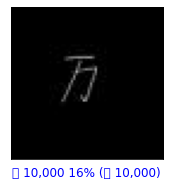

In [182]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], rounded_labels, X_test)
# plt.subplot(1,2,2)
# plot_value_array(i, predictions[i], rounded_labels)
plt.show()

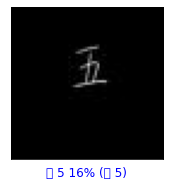

In [173]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], rounded_labels, X_test)
# plt.subplot(1,2,2)
# plot_value_array(i, predictions[i],  y_test)
plt.show()

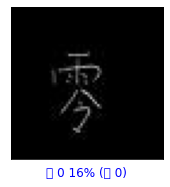

In [174]:
i = 3
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], rounded_labels, X_test)
# plt.subplot(1,2,2)
# plot_value_array(i, predictions[i],  y_test)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Glyph 19975 (\N{CJK UNIFIED IDEOGRAPH-4E07}) missing from current font.
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Glyph 21313 (\N{CJK UNIFIED IDEOGRAPH-5341}) missing from current font.
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Glyph 30334 (\N{CJK UNIFIED IDEOGRAPH-767E}) missing from current font.
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Glyph 38646 (\N{CJK UNIFIED IDEOGRAPH-96F6}) missing from current font.
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Glyph 20159 (\N{CJK UNIFIED IDEOGRAPH-4EBF}) missing from current font.
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing

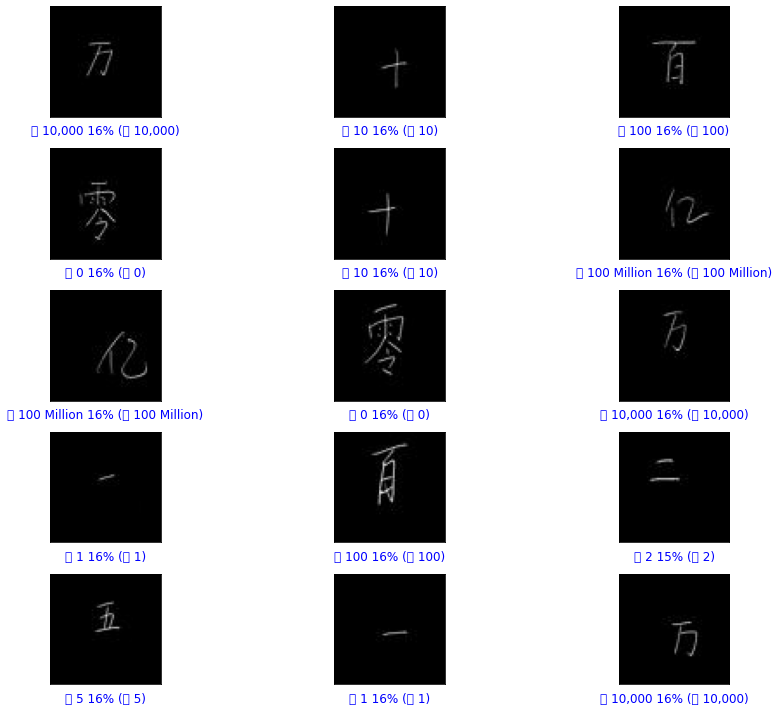

In [175]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], rounded_labels, X_test)
plt.tight_layout()
plt.show()

### 2. CNN best parameters and model

The final parameters for the NN as per the grid search were:
{'epochs': 20, 'kernel_size': (5, 5), 'optimizer__lr': 0.01, 'strides': (2, 2)}
- 'kernel_size': (5, 5)
- 'optimizer__lr': 0.01
- 'strides': (1, 1)

In [160]:
#Reinstantiate
#Set to parameters from GridSearchCV
kernel_size = (5, 5)
strides= (2, 2)
optimizer__lr=0.01
epochs = 20

model = keras.Sequential([
    
    # Specify the input shape
#     keras.Input(shape=(64, 64, 3)),
    
    # Conv and pool block 1
    keras.layers.Conv2D(32, kernel_size=kernel_size,input_shape=(64, 64, 3),strides= strides, activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(64, kernel_size=kernel_size, strides = strides, activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Dropout(0.5),
    
    keras.layers.Flatten(),

    keras.layers.Dense(15, activation="softmax"),
])


model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(optimizer__lr),
              metrics=['accuracy'])

start = time()
history = model.fit(X_train_v, y_train_v, batch_size=128,
                    epochs=epochs, validation_data=(X_valid, y_valid))

print('\n Time to train for final CNN model = {:.0f} sec'.format(time()-start))

Epoch 1/20
71/71 [==============================] - 8s 94ms/step - loss: 1.1597 - accuracy: 0.6191 - val_loss: 0.3454 - val_accuracy: 0.8942
Epoch 2/20
71/71 [==============================] - 6s 83ms/step - loss: 0.3768 - accuracy: 0.8752 - val_loss: 0.2148 - val_accuracy: 0.9276
Epoch 3/20
71/71 [==============================] - 6s 82ms/step - loss: 0.2775 - accuracy: 0.9078 - val_loss: 0.1536 - val_accuracy: 0.9493
Epoch 4/20
71/71 [==============================] - 6s 82ms/step - loss: 0.2272 - accuracy: 0.9232 - val_loss: 0.1597 - val_accuracy: 0.9502
Epoch 5/20
71/71 [==============================] - 6s 86ms/step - loss: 0.2155 - accuracy: 0.9250 - val_loss: 0.1599 - val_accuracy: 0.9458
Epoch 6/20
71/71 [==============================] - 6s 85ms/step - loss: 0.1955 - accuracy: 0.9338 - val_loss: 0.1301 - val_accuracy: 0.9547
Epoch 7/20
71/71 [==============================] - 6s 83ms/step - loss: 0.1741 - accuracy: 0.9428 - val_loss: 0.1264 - val_accuracy: 0.9636
Epoch 8/20
71

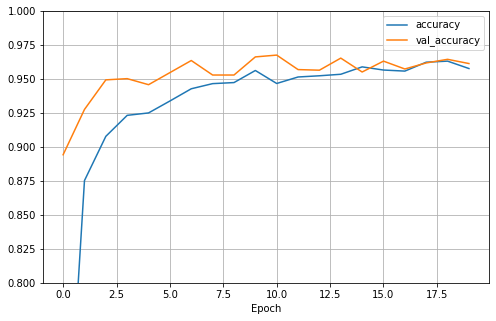

In [161]:
accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 1)
plt.xlabel('Epoch')
plt.show()

In [162]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
30/30 [==============================] - 1s 24ms/step - loss: 0.1453 - accuracy: 0.9592
test loss, test acc: [0.1452988088130951, 0.9592000246047974]


In [163]:
#https://www.tensorflow.org/tutorials/keras/classification
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(X_test)



118/118 [==============================] - 1s 9ms/step


In [164]:
predicted_classes = np.argmax(predictions, axis=1)
rounded_labels=np.argmax(y_test, axis=1)
print(classification_report(rounded_labels, predicted_classes, target_names=class_names))

                 precision    recall  f1-score   support

          零 = 0       1.00      0.99      0.99       279
          一 = 1       0.99      0.95      0.97       229
          二 = 2       0.88      0.88      0.88       251
          三 = 3       0.86      0.92      0.89       252
          四 = 4       0.98      0.98      0.98       253
          五 = 5       1.00      0.96      0.98       246
          六 = 6       0.98      0.96      0.97       247
          七 = 7       0.97      0.95      0.96       258
          八 = 8       1.00      1.00      1.00       264
          九 = 9       0.97      0.94      0.96       271
         十 = 10       0.94      0.99      0.97       226
        百 = 100       0.95      0.97      0.96       256
       千 = 1000       0.97      0.97      0.97       220
     万 = 10,000       0.93      0.97      0.95       242
亿 = 100 Million       0.98      0.95      0.96       256

       accuracy                           0.96      3750
      macro avg       0.96   

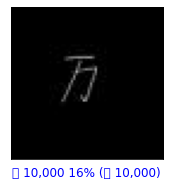

In [184]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], rounded_labels, X_test)
# plt.subplot(1,2,2)
# plot_value_array(i, predictions[i], rounded_labels)
plt.show()


/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20116 (\N{CJK UNIFIED IDEOGRAPH-4E94}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


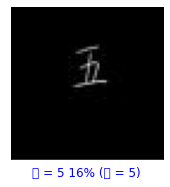

In [166]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], rounded_labels, X_test)
# plt.subplot(1,2,2)
# plot_value_array(i, predictions[i],  y_test)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Glyph 19975 (\N{CJK UNIFIED IDEOGRAPH-4E07}) missing from current font.
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Glyph 21313 (\N{CJK UNIFIED IDEOGRAPH-5341}) missing from current font.
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Glyph 30334 (\N{CJK UNIFIED IDEOGRAPH-767E}) missing from current font.
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Glyph 38646 (\N{CJK UNIFIED IDEOGRAPH-96F6}) missing from current font.
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Glyph 20159 (\N{CJK UNIFIED IDEOGRAPH-4EBF}) missing from current font.
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing

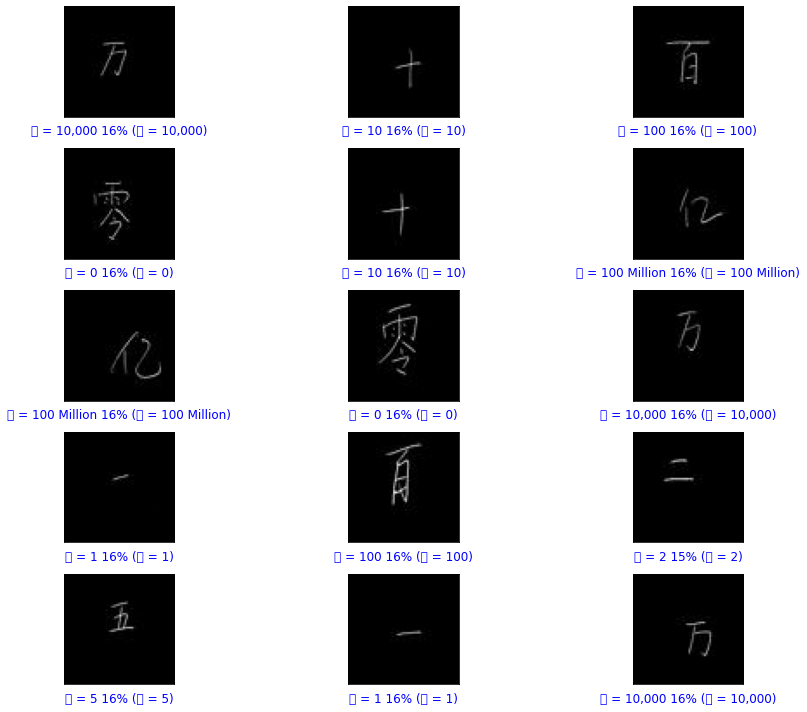

In [167]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], rounded_labels, X_test)
#   plt.subplot(num_rows, 2*num_cols, 2*i+2)
#   plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

# <a id='10'>Interpretation</a> 
It is both a surprise and an expectation that the CNN would perform remarkably better than the MLP. This is probably due to the great differences in the Chinese MNIST and the original MNIST. Digits in the original MNIST are far more centred than the motley crue of arrangements seen above, and the characters are much less uniform in their distribution around the 64x64 matrix. This makes it extremely difficult for the MLP to form geometric boundaries when training on the samples. In order to reach accuracies we might see on the original dataset, we had to invoke a computationally-expensive dual-layer CNN with epochs = 20, limiting them without due reason given the continual growth in validation accuracy as seen in the plots. This study demonstrates just how much better CNNs are than MLPs when it comes to less uniform images. 

Hopefully you enjoyed reading through yet another MNIST, displaying the wide range of possibilities from this initially easy architecture. 

![Oracle bone script](https://blogs.bl.uk/.a/6a00d8341c464853ef01b8d184cabb970c-pi)